## Filtering the Dataframe properly
1. order msut sum to 45
2. MatchID must be a valid number
3. Lane must be between 1 = 3
4. Hero ID must be between 1 - 138
5. MatchID must be unique and sum to exactly 10

In [1]:
import pandas as pd
df = pd.read_csv('large_amounts_of_data.csv')

# Keep only the first 10 consecutive rows of each match ID to prevent duplicated data
df_cleaned = df.groupby('MatchID').head(10)

# put the cleaned up data into a new file
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.to_csv('cleaned_data.csv', index=False)

df = pd.read_csv("cleaned_data.csv")
# Added in the bracer key late so the early models dont have it but it just means they were 0 so we can just make those values go to zero
df["bracer"].fillna(int(0), inplace=True)

#1. the ordrr must sum to 45
grouped = df.groupby("MatchID")["Order"].sum()
filtered_match_ids = grouped[grouped == 45].index
# Create a new DataFrame with only the rows corresponding to the filtered "MatchID"
df = df[df["MatchID"].isin(filtered_match_ids)]

# 2 and 3 remove the values of the dataframe where the match id is invalid or the lane is biggerr than 3 as this is ambigous and bad data 
cleaned_df = df[(df['MatchID'] > 100000) & (df["Lane"] < 4) & (df["Lane"] > 0)]

#4. hero id's between
cleaned_df = cleaned_df[cleaned_df["Hero ID"].between(1, 138)]

# 5. A valid match id must have exactly 10 matches
matchID_counts = cleaned_df['MatchID'].value_counts()
valid_matchID = matchID_counts[matchID_counts == 10].index
final_df = cleaned_df[cleaned_df["MatchID"].isin(valid_matchID)]
df_cleaned.to_csv('cleaned_data.csv', index=False)

# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', None)
final_df


,Hero ID,Team,Order,MatchID,Lane,smoke_of_deceit,boots,flask,blood_grenade,clarity,...,ring_of_regen,sobi_mask,null_talisman,buckler,headdress,ring_of_basilius,wind_lace,boots_of_elves,dust,bracer
10,13,1,9,7425319964,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
11,46,1,6,7425319964,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
12,138,1,2,7425319964,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
13,83,1,5,7425319964,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
14,77,1,0,7425319964,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117741,136,0,4,6856407334,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117742,52,0,9,6856407334,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117743,85,0,1,6856407334,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117744,92,0,7,6856407334,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


## Fnding Optimal Random Forrest Model 

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]

# test train splitting 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

#using optimal params to train and then test
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)


print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)
print("Test Set Accuracy:", test_accuracy)


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 0.8238143119449614
Test Set Accuracy: 0.8230399408284024


## Random  Forrest Feature Importance

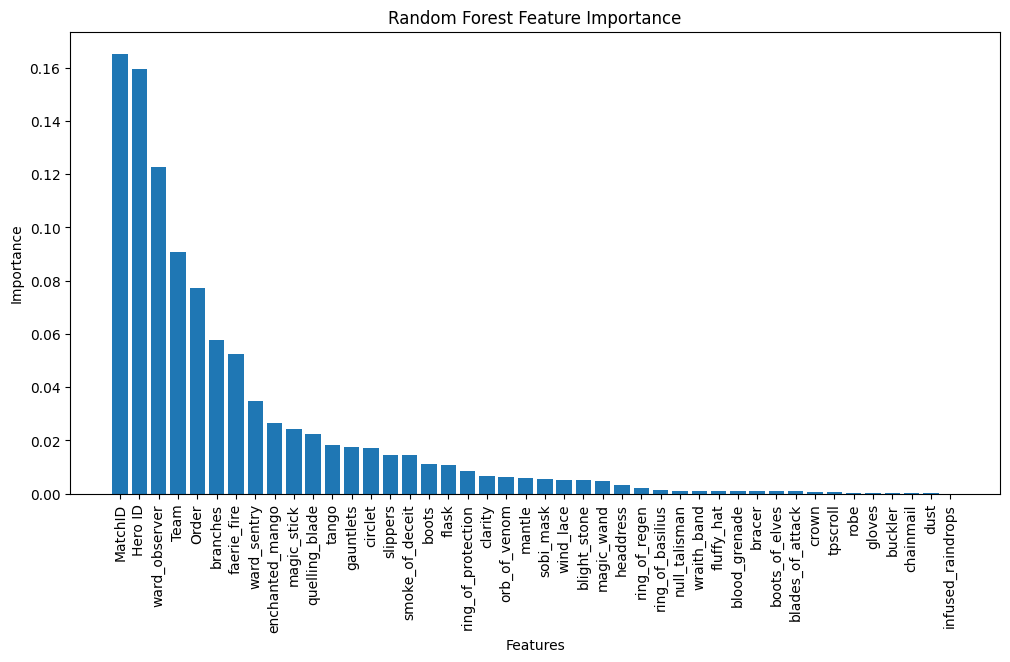

In [8]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]

decision_tree_model = RandomForestClassifier()
decision_tree_model.fit(X, y)
feature_importances = decision_tree_model.feature_importances_

importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
sorted_importances_df = importances_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 6))
plt.bar(sorted_importances_df['Feature'], sorted_importances_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()


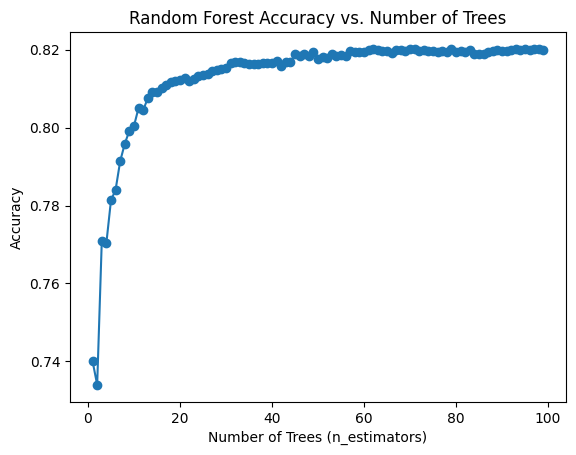

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vary the number of trees from 1 to 1000 in intervals of 10 and record accuracy
n_estimators_range = range(1, 100, 1)
accuracy_scores = []

for n_estimators in n_estimators_range:
    random_forest_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    random_forest_model.fit(X_train, y_train)

    # evaluate on test set
    y_pred = random_forest_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the results
plt.plot(n_estimators_range, accuracy_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.show()


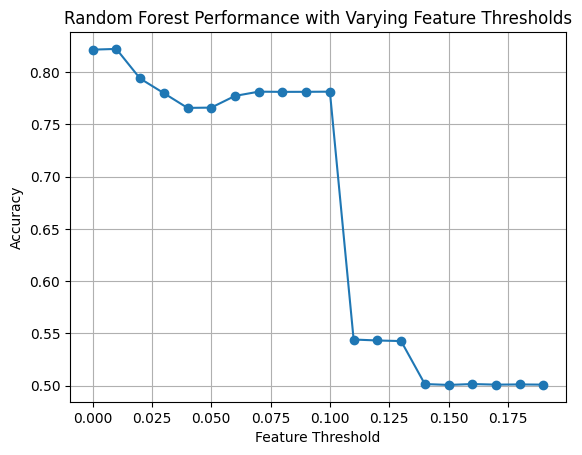

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)

# different threhsolds to test
thresholds = np.arange(0, 0.2, 0.01)
accuracies = []

for threshold in thresholds:
    # Feature selection based on importance
    sfm = SelectFromModel(random_forest_model, threshold=threshold)
    sfm.fit(X_train, y_train)

    if np.sum(sfm.get_support()) > 0:
        X_train_selected = sfm.transform(X_train)
        X_test_selected = sfm.transform(X_test)

        # train model on selcted features above threshold
        random_forest_model_selected = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
        random_forest_model_selected.fit(X_train_selected, y_train)

    
        y_pred_selected = random_forest_model_selected.predict(X_test_selected)
        accuracy_selected = accuracy_score(y_test, y_pred_selected)
        accuracies.append(accuracy_selected)
    else:
        print(f"No features selected for threshold {threshold}")

#plot the results of different accuracy versus the threhold for features
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Feature Threshold')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance with Varying Feature Thresholds')
plt.grid(True)
plt.show()


##  K Nearest Neighbors Model

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


special_features = ["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]


X_special = final_df[special_features]
y = final_df["Lane"]
X_train, X_test, y_train, y_test = train_test_split(X_special, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model =  KNeighborsClassifier(metric='manhattan', n_neighbors=13, weights='distance')
knn_model.fit(X_train_scaled, y_train)


y_pred = knn_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8014515532544378
Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.79      0.78      8467
           2       0.93      0.86      0.89      4930
           3       0.76      0.78      0.77      8235

    accuracy                           0.80     21632
   macro avg       0.82      0.81      0.81     21632
weighted avg       0.80      0.80      0.80     21632

Confusion Matrix:
[[6660  155 1652]
 [ 324 4229  377]
 [1608  179 6448]]


## Find Optimal KNN PArams (takes long time)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


special_features = ["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
                    "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
                    "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
                    "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
                    "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
                    "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]

X_special = final_df[special_features]
y = final_df["Lane"]
X_train, X_test, y_train, y_test = train_test_split(X_special, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'n_neighbors': [9, 11, 13, 15],  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


knn_model = KNeighborsClassifier()

# grid search with cross validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


print("Best Parameters:", grid_search.best_params_)
best_knn_model = grid_search.best_estimator_

y_pred = best_knn_model.predict(X_test_scaled)

# Evaluating the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Best Parameters:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

special_features = ["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
                    "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
                    "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
                    "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
                    "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
                    "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]

X_special = final_df[special_features]
y = final_df["Lane"]
X_train, X_test, y_train, y_test = train_test_split(X_special, y, test_size=0.2, random_state=42)

best_knn_params = {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
knn_model = KNeighborsClassifier(**best_knn_params)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred_test = knn_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print the test accuracy
print(f"Test Set Accuracy for KNN: {test_accuracy}")


Test Set Accuracy for KNN: 0.8014515532544378


## Optimal Params in a Table

In [19]:
import pandas as pd

# Data for the table
data = {
    'Model': ['KNN', 'Gradient Boosting', 'Random Forest'],
    'Best Parameters': [
        {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'},
        {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150},
        {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    ],
    'Testing Accuracy': [0.8014515532544378, 0.8436575443786982, 0.8230399408284024]
}

# Create a DataFrame
df = pd.DataFrame(data)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
df


,Model,Best Parameters,Testing Accuracy
0,KNN,"{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}",0.801452
1,Gradient Boosting,"{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}",0.843658
2,Random Forest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.823040


## Confusion Matrix for the KNN printed

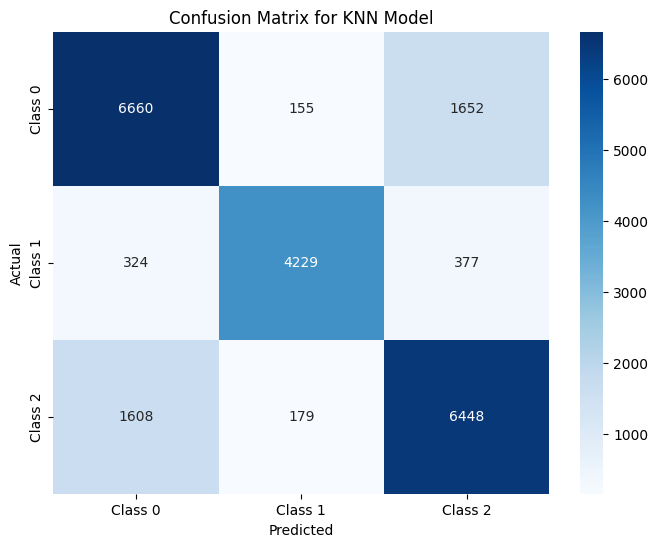

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Given confusion matrix
conf_matrix = [[6660, 155, 1652],
               [324, 4229, 377],
               [1608, 179, 6448]]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Model')
plt.show()


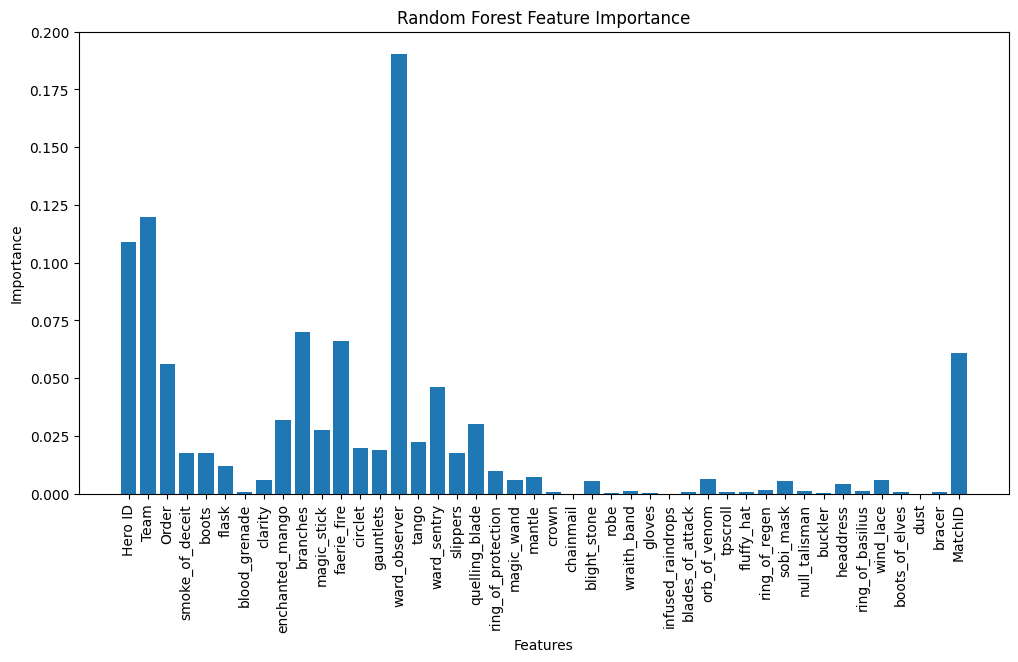

Selected Features with Importance > 0.02:
['Hero ID', 'Team', 'Order', 'enchanted_mango', 'branches', 'magic_stick', 'faerie_fire', 'ward_observer', 'tango', 'ward_sentry', 'quelling_blade', 'MatchID']


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


random_forest_model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
random_forest_model.fit(X_train, y_train)

feature_importances = random_forest_model.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Filter features with importance above 0.02
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.02]['Feature'].tolist()


plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()

# features above
print("Selected Features with Importance > 0.02:")
print(selected_features)


## Find Optimal Paramsters for Gradient Boosting Classifier (takes long time)

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Create the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)


grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


best_gb_model = grid_search.best_estimator_
y_pred = best_gb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


## Optimal Gradient Boosting Classifier

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# optimal params from Grid search
gb_model = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, random_state=42)
gb_model.fit(X_train_scaled, y_train)

test_accuracy = accuracy_score(y_test, gb_model.predict(X_test_scaled))
print("Test Set Accuracy:", test_accuracy)


Test Set Accuracy: 0.8436575443786982


## Top 4 models analyzed side by side

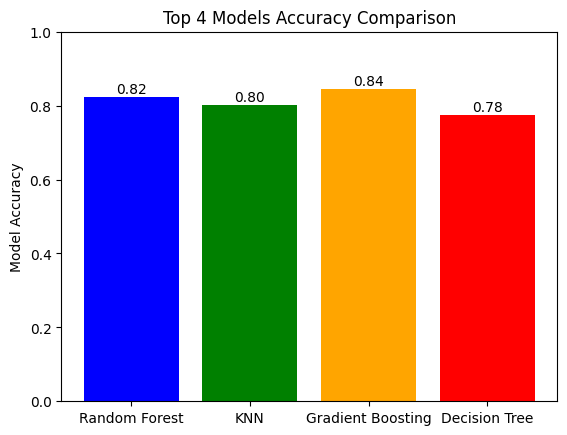

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the momodels with found optimal paramaters
rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=13, weights='distance')
knn_model.fit(X_train_scaled, y_train)

gb_model = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, random_state=42)
gb_model.fit(X_train_scaled, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)


rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test_scaled))
knn_accuracy = accuracy_score(y_test, knn_model.predict(X_test_scaled))
gb_accuracy = accuracy_score(y_test, gb_model.predict(X_test_scaled))
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test_scaled))


models = ['Random Forest', 'KNN', 'Gradient Boosting', 'Decision Tree']
accuracies = [rf_accuracy, knn_accuracy, gb_accuracy, dt_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1) 
plt.ylabel('Model Accuracy')
plt.title('Top 4 Models Accuracy Comparison')

# accuracy on each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", color='black', ha='center')

plt.show()


## Sanity checks on the Data 

In [13]:
# #confirmation check that we cleaned properly
result = final_df.groupby("MatchID")["Order"].sum()
result = result.reset_index()
filter = result[result["Order"] != 45]
filter

# should be empy


,MatchID,Order


## Unimportant items we should remove ??

In [3]:
columns_sum_less_than_50 = final_df.columns[final_df.sum() < 50].tolist()
sum_of_columns = final_df[columns_sum_less_than_50].sum()
print(sum_of_columns)

chainmail            17
infused_raindrops     0
dust                 17
dtype: int64
